## Лабораторная работа №2 (курс "Математические методы анализа текстов")


#### Тема: Языковое моделирование и определение языка.


**Выдана**:   13 марта 2017

**Дедлайн**:   <font color='red'>9:00 утра 27 марта 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 2.7)

#### Правила:

Результат выполнения задания $-$ отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев $-$ тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 2.7). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение семинаристов в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе Вам предстоит реализовать n-грамную языковую модель с несколькими видами сглаживания:
- Add-one smoothing
- Stupid backoff
- Interpolation smoothing
- Kneser-Ney smoothing

Вы обучите ее на готовых корпусах, оцените качество и проведете ряд экспериментов. Во второй части задания Вы примените реализованную модель (но с буквенными n-граммами) к задаче распознавания языка. 


# Языковые модели

Цель языкового моделирования заключается в том, чтобы присвоить некоторые вероятности предложениям. Задача состоит в подсчете вероятности $P(W) = P(w_1, \dots, w_n)$ или $P(w_n \mid w_1, \dots, w_{n-1})$. Модель, умеющая вычислять хотя бы одну из этих двух вероятностей, называется **языковой моделью** (LM от Language Model).

Согласно **цепному правилу** (chain rule):

$$P(X_1, \dots, X_n) = P(X_1)P(X_2 \mid X_1)\dots P(X_n \mid X_1, \dots, X_{n-1}).$$ 

Также мы знаем, что

$$
    P(X_n \mid X_1, \dots, X_{n-1}) = \frac{P(X_1, \dots, X_n)}{P(X_1, \dots, X_{n-1})},
$$

следовательно, для того чтобы оценить $P(X_n \mid X_1, \dots, X_{n-1})$ нужно посчитать $P(X_1, \dots, X_n)$ и $P(X_1, \dots, X_{n-1})$. Но эти вероятности будут чрезвычайно малы, если мы возьмем большое $n$, так множество предложений из $n$ слов растет экспоненциально. Для упрощения применим **марковское предположение**: 

$$P(X_n \mid X_1, \dots, X_{n-1}) = P(X_n \mid X_{n - k + 1}, \dots, X_{n-1})$$

для некоторого фиксированного (небольшого) $k$. Это предположение говорит о том, что $X_{n}$ не зависит от $X_{1}, \dots, X_{n - k}$, то есть на следующее слово влияет лишь контекст из предыдущих $k - 1$ слова. Таким образом, мы получаем финальную вероятность:

$$
    P(w_1, \dots, w_n) = \prod_i P(w_i \mid w_{i-k+1}, \dots, w_{i - 1}).
$$

Далее для краткости будем обозначать $w_{i-k}^i := w_{i-k}, \dots, w_{i}$.

## Хранилище n-грам

Для начала выполним вспомогательную работу. Следуйте комментариям, чтобы написать NGramStorage с удобным интерфейсом.

In [1]:
import re
import math
import random
from collections import Counter
import numpy as np
from sklearn.cross_validation import train_test_split

/home/ospanoff/.pyenv/versions/2.7.11/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class NGramStorage:
    """Storage for ngrams' frequencies.
    
    Args:
        sents (list[list[str]]): List of sentences from which ngram
            frequencies are extracted.
        max_n (int): Upper bound of the length of ngrams.
            For instance if max_n = 2, then storage will store
            0, 1, 2-grams.
            
    Attributes:
        max_n (Readonly(int)): Upper bound of the length of ngrams.
    """
        
    def __init__(self, sents=[], max_n=0):
        # self._ngrams[K] should have the following interface:
        # self._ngrams[K][(w_1, ..., w_K)] = number of times w_1, ..., w_K occured in words
        # self._ngrams[0][()] = number of all words
        self.__max_n = max_n
        self.__ngrams = {
            i: Counter(tuple(sent[j: j + i]) for sent in sents for j in range(len(sent) - i + (i > 0)))
            for i in range(self.__max_n + 1)
        }
        
    def add_unk_token(self):
        """Add UNK token to 1-grams."""
        # In order to avoid zero probabilites 
        if self.__max_n == 0 or u'UNK' in self.__ngrams[1]:
            return
        self.__ngrams[0][()] += 1
        self.__ngrams[1][(u'UNK',)] = 1
        
    @property
    def max_n(self):
        """Get max_n"""
        return self.__max_n
        
    def __getitem__(self, k):
        """Get dictionary of k-gram frequencies.
        
        Args:
            k (int): length of returning ngrams' frequencies.
            
        Returns:
            Dictionary (in fact Counter) of k-gram frequencies.
        """
        # Cheking the input
        if not isinstance(k, int):
            raise TypeError('k (length of ngrams) must be an integer!')
        if k > self.__max_n:
            raise ValueError('k (length of ngrams) must be less or equal to the maximal length!')
        return self.__ngrams[k]
    
    def __call__(self, ngram):
        """Return frequency of a given ngram.
        
        Args:
            ngram (tuple): ngram for which frequency should be computed.
            
        Returns:
            Frequency (int) of a given ngram.
        """
        # Cheking the input
        if not isinstance(ngram, tuple):
            raise TypeError('ngram must be a tuple!')
        if len(ngram) > self.__max_n:
            raise ValueError('length of ngram must be less or equal to the maximal length!')
        if len(ngram) == 1 and ngram not in self.__ngrams[1]:
            return self.__ngrams[1][(u'UNK', )]
        return self.__ngrams[len(ngram)][ngram]

## Оценка качества

Скачайте brown корпус, обучите модель и протестируйте на нескольких примерах последовательностей.

In [3]:
import nltk
# Uncomment next row and download brown corpus
# nltk.download()
from nltk.corpus import brown

In [4]:
all_sents = list(brown.sents())
random.shuffle(all_sents)
print('Number of all sentences = {}'.format(len(all_sents)))
train_sents = all_sents[:int(0.8 * len(all_sents))]
test_sents = all_sents[int(0.8 * len(all_sents)):]
print('Number of train sentences = {}'.format(len(train_sents)))
print('Number of test sentences = {}'.format(len(test_sents)))

Number of all sentences = 57340
Number of train sentences = 45872
Number of test sentences = 11468


In [5]:
# Create storage of 0, 1, 2, 3-grams
storage = NGramStorage(train_sents, 3)

In [6]:
# It's time to test your code
print(storage(('to', 'be')))
print(storage(('or',)))
print(storage(('not', 'to', 'be')))
print(storage(('somethingweird',)))
print(storage(()))

1385
3253
26
0
928114


Для численного измерения качества языковой модели определим **перплексию**:

$$
    {\mathbb{P}}(w_1, \dots, w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_i P(w_i \mid w_{i - k}, \dots, w_{i - 1})\right)^{-\frac1N},
$$

Вижно, что минимизация перплексии эквивалентна максимизации правдоподобия модели.

Реализуйте функцию по подсчету перплексии. Обратите внимание, что перплексия по корпусу равна произведению вероятностей **всех** предложений в степени $-\frac1N$, где $N -$ суммарная длина всех предложений.

In [7]:
def perplexity(estimator, sents):
    '''Estimate perplexity of the sequence of words using prob_estimator.'''
    perp = 0
    N = 0
    for sent in sents:
        N += len(sent)
        perp += np.log(estimator.prob(sent) + 1e-50)
    
    return np.exp(-perp / N)

## Оценка вероятностей n-грам

Первый и простейший способ оценки вероятностей N-грам следующий:

$$
    \hat P_{S}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N)}{c(w_1^{N-1})}.
$$

где $c(w_1^N)$ — это число последовательностей $w_1, \dots, w_N$ в корпусе, $S$ символизирует Straightforward. 

In [8]:
class StraightforwardProbabilityEstimator:
    """Class for simplest probability estimations of type P(word | context).
    
    P(word | context) = c(context + word) / c(context), where
    c(sequence) - number of occurances of the sequence in the corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
    """
    
    def __init__(self, storage):
        self.__storage = storage
        # Adding UNK token to avoid zero probabilities
        self.__storage.add_unk_token()
        
    def cut_context(self, context):
        
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if self.__storage.max_n == 1:
            return ()
        if len(context) + 1 > self.__storage.max_n:
            context = context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, (unicode, str)):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('word must be a tuple!')
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)
        # Avoiding 0 / 0.
        if context_counts == 0:
            return 0.
        return 1. * phrase_counts / context_counts
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [9]:
# Initialize estimator
simple_estimator = StraightforwardProbabilityEstimator(storage)

# Estimating perplexity
print('Simple estimator perplexity = {}'.format(perplexity(simple_estimator, test_sents)))
print(simple_estimator.prob('To be'.split()))
print(simple_estimator.prob('To be or not to be'.split()))

Simple estimator perplexity = 250.415036669
1.5084337609e-05
0.0


In [10]:
print 'To be...\n'
for sent in train_sents:
    if sent[:2] == ['To', 'be']:
        print ' '.join(sent[:5])

print '\nTo be or...\n'
for sent in train_sents:
    if sent[:3] == ['To', 'be', 'or']:
        print sent

To be...

To be Katharine Ross ,
To be human , he
To be eligible to borrow
To be fit , one
To be checked out further
To be sure of matching
To be sure , in
To be on the safe
To be presiding officer of
To be passive , to
To be reminded of this

To be or...



Посчитаем перплексию униграмной модели.

In [11]:
uni_storage = NGramStorage(train_sents, 1)
uni_simple_estimator = StraightforwardProbabilityEstimator(uni_storage)
print('Simple estimator perplexity = {}'.format(perplexity(uni_simple_estimator, test_sents)))

Simple estimator perplexity = 106.361326075


In [12]:
print(uni_simple_estimator.prob('To be or not to be'.split()))

3.19891402357e-15


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Какие выводы можно сделать? Почему $P(\text{To be or not to be}) = 0$, хотя мы и добавили UNK токен?  
**A:** В обучающей выборке нету этого предложения хотя бы с "To be or". Т.е. вероятность этого триграма 0, соответственно вся вероятность предложения = 0. А UNK мы добавляли для 1-грамов. Поэтому, если мы проверим для униграмной модели, то получим не 0

**Q:** Почему перплексия униграмной модели меньше, чем триграмной?  
**A:** Потому, что вероятность встретить только одно слово выше, чем встретить три подряд идущих слова. Если все слова из теста есть в обучающей выборке, то вероятность не 0. Соотвественно перплексия маленькая.

## Add-one smoothing

Простейший вид сглаживания — **сглаживание Лапласа**. Чтобы избавиться от нулевых вероятностей $P(w_{N} \mid w_1^{N - 1})$, будем использовать формулу:

$$
    \hat P_{AOS}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N) + \delta}{c(w_1^{N-1}) + \delta V},
$$

где $V$ — это размер словаря, а $\delta$ — некоторая фиксированная константа.

Реализуйте класс, осуществляющий сглаживание Лапласа. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [13]:
class LaplaceProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = (c(context + word) + delta) / (c(context) + delta * V), where
    c(sequence) - number of occurances of the sequence in the corpus,
    delta - some constant,
    V - number of different words in corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): Smoothing parameter.
    """
    
    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if len(context) + 1 > self.__storage.max_n:
            context = context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, (unicode, str)):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('context must be a tuple!')
            
        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)

        return 1. * (phrase_counts + self.__delta) / (context_counts + self.__delta * len(self.__storage[1]))
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

Подберите наилучший параметр $\delta$ для данного корпуса.

In [14]:
%%time
deltas = np.linspace(1e-8, 0.01, 50)
perp = np.inf
perps = []
for delta in deltas:
    tmp = perplexity(LaplaceProbabilityEstimator(storage, delta), test_sents)
    perps += [tmp]
    if tmp < perp:
        perp = tmp
        best_delta = delta
    
# best_delta = 1.
print('Best delta:', best_delta)

# Initialize estimator
laplace_estimator = LaplaceProbabilityEstimator(storage, best_delta)

# Let's make some estimations
print('Laplace estimator perplexity = {}'.format(perplexity(laplace_estimator, test_sents)))
print(laplace_estimator.prob('To be'.split()))

('Best delta:', 0.00040817285714285717)
Laplace estimator perplexity = 133.980012654
1.42196692297e-05
CPU times: user 57.5 s, sys: 233 ms, total: 57.7 s
Wall time: 57.3 s


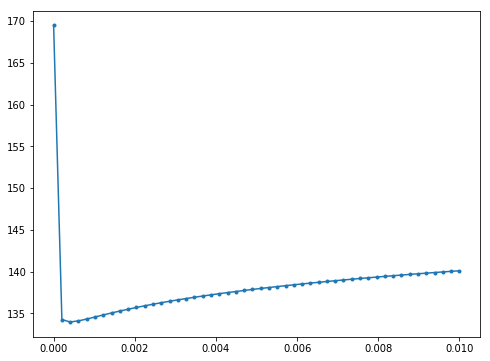

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(deltas, perps, '.-')
plt.show()

## Stupid backoff

Идея **простого отката** довольно понятна. Если у нас есть достаточно информцаии для подсчета вероятности $k$-грам, то будем использовать $k$-грамы. Иначе будем использовать вероятности $(k-1)$-грам с некоторым множителем, например, $0.4$, и так далее. К сожалению, в данном случае мы получим не вероятностное распределение, но в большинстве задач это не имеет принципиального значения. Если это все же важно, то необходимо подобрать множитель соответствующим образом.

Реализуйте класс, симулирующий сглаживание простым откатом. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [16]:
class StupidBackoffProbabilityEstimator:
    """Class for stupid backoff probability estimations.
    
    P(word | context) =
        P'(word | context),                  if  P'(word | context) > 0;
        P'(word | context[1:]) * multiplier, if  P'(word | context) == 0
                                             and P'(word | context[1:]) > 0;
        ...
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        multiplier (float): Multiplier which is used for probability estimations.
    """
    
    def __init__(self, base_estimator, multiplier=0.1):
        self.__base_estimator = base_estimator
        self.__mult = multiplier
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        mult = 1.
        prob = self.__base_estimator(word, context)
        for i in range(len(context) + 1):
            prob = self.__base_estimator(word, context[i:])
            if prob > 0:
                break
            mult *= self.__mult

        return mult * prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [17]:
# Initialize estimator
sbackoff_estimator = StupidBackoffProbabilityEstimator(simple_estimator, .4)

# Let's make some estimations
print('Stupid backoff estimator perplexity = {}'.format(perplexity(sbackoff_estimator, test_sents)))
print(sbackoff_estimator.prob('To be'.split()))

Stupid backoff estimator perplexity = 121.549621152
1.5084337609e-05


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Почему бессмысленно измерять перплексию в случае **Stupid backoff**?  
**A:** Потому, что в этом случае мы получим не вероятностное распределение


## Interpolation smoothing

В данном случае идея сглаживания посредством **интерполяции** также крайне проста. Пусть у нас есть $N$-грамная модель. Заведем вектор $\bar\lambda = (\lambda_1, \dots, \lambda_N)$, такой, что $\sum_i\lambda_i = 1$ и $\lambda_i \geq 0$. Тогда

$$
    \hat P_{IS}(w_{N} \mid w_1^{N-1}) = \sum_{i=1}^N \lambda_i \hat P_{S}(w_N \mid w_{N-i+1}^{N-1}).
$$

Придумайте, как обойтись одним вектором $\bar\lambda$, т.е. пользоваться им как в случае контекста длины $N$, так и при контексте меньшей длины (например, в начале предложения). Если мы просто обрубим сумму, то у нас уже не будет вероятностное распределение, что, конечно же, плохо.

In [18]:
class InterpolationProbabilityEstimator:
    """Class for interpolation probability estimations.
    
    P(word | context) =
        lambda_N * P'(word | context) +
        lambda_{N-1} * P'(word | context[1:]) +
        ... +
        lambda_1 * P'(word)
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        lambdas (np.array[float]): Lambdas which are used for probability estimations.
    """
    
    def __init__(self, base_estimator, lambdas):
        self.lambdas = lambdas
        self.__base_estimator = base_estimator
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """        
        N = min(len(self.lambdas), len(context) + 1)
        context = context[-N + 1:]
        lambdas = self.lambdas[-N:][::-1]
        lambdas = np.array(lambdas) / np.sum(lambdas)
        prob = 0.0
        for i in range(N):
            prob += lambdas[i] * self.__base_estimator(word, context[i:])

        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [19]:
import numpy as np

# Initialize estimator
interpol_estimator = InterpolationProbabilityEstimator(simple_estimator, np.array([0.2, 0.2, 0.6]))

# Let's make some estimations
print('Interpolation estimator perplexity = {}'.format(perplexity(interpol_estimator, test_sents)))
print(interpol_estimator.prob('To be'.split()))

Interpolation estimator perplexity = 91.8909123944
1.18101057322e-05


Обучить значения параметров $\lambda$ можно с помощью EM-алгоритма, но мы не будем этого здесь делать.

## Kneser-Ney smoothing

Идея данного сглаживания заключается в том, что словам, которые участвуют в большом количестве контекстов, присваиваются большие вероятности, а те, которые используются в паре-тройке контекстов, получают маленькие вероятности. Авторы данного сглаживания формализовали это следующим образом. Введем обозначения

$$
    N_{c}(w) := \left|\{\hat w : c(\hat w, w) > 0\}\right|
$$

$-$ число N-грамм, в которых последней частью идёт $w$ (слово или последовательность слов).

Опеределим рекурентное соотношение:

$$
    \hat P_{KN} (w_1) = \frac{N_{c}(w_1)}{\sum_{w} N_{c}(w)},
$$

$$
    \hat P_{KN}(w_{i} \mid w_{i - n + 1}^{i-1}) = \frac{{\rm max}\{c(w_{i -n +1}^i) - \delta, 0\}}{\sum_{w}c(w_{i - n + 1}^{i-1}, w)} + \lambda(w^{i-1}_{i-n+1}) \hat P_{KN}(w_{i} \mid w^{i-1}_{i-n+2}).
$$

где

$$
\lambda(w^{i-1}_{i-n+1}) = \frac{\delta}{\sum_{w}c(w_{i - n + 1}^{i-1}, w)}N_{c}(w_{i-n+1}^{i-1})
$$

$-$ весовой множитель.


Реализуйте данный подход.

In [20]:
class KneserNeyProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = ...
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): KneserNey parameter.
    """

    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        
        # how many times there were len(prefix) + 1 sequences that have prefix in it
        self.__prefixesVal = {i: Counter() for i in range(1, storage.max_n)}
        for i in range(1, storage.max_n):
            for cntxt, val in storage[i + 1].items():
                self.__prefixesVal[i][cntxt[:i]] += val
        
        # how many times a postfix was the postfix of words in the corpus
        self.__postfixesCount = {
            i: Counter(cntxt[-i:] for cntxt in storage[i + 1].keys()) for i in range(1, storage.max_n)
        }

    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if len(context) + 1 > self.__storage.max_n:
            context = context[-self.__storage.max_n + 1:]
        return context

    def Nc(self, postfix):
        return self.__postfixesCount[len(postfix)][postfix]

    def Sc(self, prefix):
        return self.__prefixesVal[len(prefix)][prefix]

    def prob_kn(self, word, context):
        if len(context) == 0:
            return 1.0 * self.Nc((word,)) / len(self.__postfixesCount[1])
        else:
            Sc = self.Sc(context)
            Nc = self.Nc(context)
            if Sc > 0:
                mx = 1.0 * max(self.__storage(context + (word,)) - self.__delta, 0)
                lambda_ = 1.0 * self.__delta * Nc
                return (mx + lambda_ * self.prob_kn(word, context[1:])) / Sc
            else:
                return 0.0

    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, unicode) and not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('word must be a tuple!')
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        
        return self.prob_kn(word, context)
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            p = self(sent[i], tuple(sent[:i]))
            prob *= p
        return prob

In [21]:
%%time
# Initialize estimator
kn_estimator = KneserNeyProbabilityEstimator(storage)

CPU times: user 3.69 s, sys: 113 ms, total: 3.8 s
Wall time: 3.74 s


In [22]:
# Estimating perplexity
print('Kneser-Ney estimator perplexity = {}'.format(perplexity(kn_estimator, test_sents)))
print(kn_estimator.prob('To be'.split()))
print(kn_estimator.prob('To be or not to be'.split()))

Kneser-Ney estimator perplexity = 223.323678763
2.26546408741e-05
1.51558182779e-12


## Определение языка документа

**Постановка задачи:**  
Одна из задач, которая может быть решена при помощи языковых моделей $-$ **определение языка документа**. Реализуйте два классификатора для определения языка документа:
1. Наивный классификатор, который будет учитывать частоты символов и выбирать язык текста по признаку: распределение частот символов "наиболее похоже" на распределение частот символов в выбранном языке.
2. Классификатор на основе языковых моделей. Сами придумайте, как он должен работать.  
_Подсказка_: лучше считать n-грамы не по словам, а по символам.

---

**Как представлены данные:**  
Во всех текстовых файлах на каждой строчке записано отдельное предложение.
1. В папке _data_ находятся две папки: _full_ и _plain_. В _full_ находятся тексты в той форме, что они были взяты из сети, в _plain_ находятся те же самые тексты, но с них сначала была снята диакритика, а затем русский и греческий тексты были транслитерованы в английский.
2. В каждой из папок _full_ и _plain_ находятся папки _train_ и _test_.
3. В _train_ находятся файлы с текстами с говорящими именами, например, _ru.txt_, _en.txt_.
4. В _test_ находятся файлы _1.txt_, _2.txt_, $\dots$ в которых хранятся тексты, язык которых нужно определить. В этой же папке находится файл _ans.csv_, в котором вы можете найти правильные ответы и проверить, насколько хорошо сработали Ваши алгоритмы.

---

**Что нужно сделать:**  
Напишите два своих классификатора (которые описаны в постановке задачи) и получите максимально возможное accuracy на test-сете. Разрешается использовать только _train_ для обучения.

---

**В данном задании мы не предоставляем стартового кода!**

In [23]:
import re
import glob
import pandas as pd
import numpy as np

In [24]:
class LangNGramStorage:
    def __init__(self, base_path, list_of_filename, max_n):
        self.__regexp = re.compile(r'([~!@#$%^&*()_+=;:"{}\[\]<>,.?\n\r\t|\/0-9]| - |[\x00-\x1F])')
        self.__max_n = max_n
        self.__storage = dict()
        for fname in list_of_filename:
            lang = fname.split('.')[0]
            
            data = []
            with open(base_path + fname, 'r') as f:
                for line in f:
                    line = self.regexp.sub('', line).decode('utf-8').lower()
                    data += line.split(' ')

            self.__storage[lang] = NGramStorage(data, self.__max_n)
            
    @property
    def max_n(self):
        """Get max_n"""
        return self.__max_n
    
    @property
    def storage(self):
        """Get ngrams"""
        return self.__storage
    
    @property
    def regexp(self):
        """Get ngrams"""
        return self.__regexp
    
    def __getitem__(self, lang):
        return self.__storage[lang]

In [25]:
def accuracy(clf, path, ans):
    res = []
    for i, lang in ans:
        res += [clf.predict(path, '%s.txt' % i) == lang]
        
    return 100.0 * np.mean(res)

In [26]:
FULL_TRAIN_PATH = 'data/full/train/'
FULL_TEST_PATH = 'data/full/test/'
full_train_files = glob.glob1(FULL_TRAIN_PATH, '*.txt')
full_ans = pd.read_csv(FULL_TEST_PATH + 'ans.csv', header=None).values

PLAIN_TRAIN_PATH = 'data/plain/train/'
PLAIN_TEST_PATH = 'data/plain/test/'
plain_train_files = glob.glob1(PLAIN_TRAIN_PATH, '*.txt')
plain_ans = pd.read_csv(PLAIN_TEST_PATH + 'ans.csv', header=None).values

## Naive classifier

В наивном классификаторе считаются частоты символов и сравниваются по евклидовой метрике (то, что попалось под руку =)). Пространство расширяется до объединения символов, и новые измерения обнуляются. Таким образом можно применять евклидову метрику

In [40]:
class NaiveClassifier:
    def __init__(self, storage):
        self.__storage = storage

    def dist(self, p1, p2):
        s = 0
        for i in range(1, p1.max_n + 1):
            syms_p1 = p1[i]
            syms_p2 = p2[i]
            sum_p1 = sum(syms_p1.values())
            sum_p2 = sum(syms_p2.values())
            for sym in set(syms_p1.keys()).union(syms_p2.keys()):
                s += (1.0 * syms_p1[sym] / sum_p1 - 1.0 * syms_p2[sym] / sum_p2) ** 2

            return np.sqrt(s)
        
    def predict(self, base_path, fname):
        data = []
        with open(base_path + fname, 'r') as f:
            for line in f:
                line = self.__storage.regexp.sub('', line).decode('utf-8').lower()
                data += line.split(' ')

        symbols = NGramStorage(data, self.__storage.max_n)
        m = np.inf
        language = None
        for lang in self.__storage.storage.keys():
            dist = self.dist(self.__storage[lang], symbols)
            if dist < m:
                m = dist
                language = lang
                
        return language

##### FULL: 1-gram

In [28]:
%%time
storage_uni_full = LangNGramStorage(FULL_TRAIN_PATH, full_train_files, 1)

CPU times: user 1min 8s, sys: 493 ms, total: 1min 9s
Wall time: 1min 8s


In [41]:
%%time
clf = NaiveClassifier(storage_uni_full)
print 'Точность:', accuracy(clf, FULL_TEST_PATH, full_ans)

Точность: 100.0
CPU times: user 3.85 s, sys: 33.3 ms, total: 3.88 s
Wall time: 3.84 s


##### FULL: 3-gram

In [42]:
%%time
storage_tri_full = LangNGramStorage(FULL_TRAIN_PATH, full_train_files, 3)

CPU times: user 2min 1s, sys: 713 ms, total: 2min 2s
Wall time: 2min 1s


In [43]:
%%time
clf = NaiveClassifier(storage_tri_full)
print 'Точность:', accuracy(clf, FULL_TEST_PATH, full_ans)

Точность: 100.0
CPU times: user 6.93 s, sys: 53.3 ms, total: 6.98 s
Wall time: 6.9 s


##### PLAIN: 1-gram

In [44]:
%%time
storage_uni_plain = LangNGramStorage(PLAIN_TRAIN_PATH, plain_train_files, 1)

CPU times: user 1min 9s, sys: 497 ms, total: 1min 9s
Wall time: 1min 9s


In [45]:
%%time
clf = NaiveClassifier(storage_uni_plain)
print 'Точность:', accuracy(clf, PLAIN_TEST_PATH, plain_ans)

Точность: 99.5833333333
CPU times: user 3.81 s, sys: 20 ms, total: 3.83 s
Wall time: 3.8 s


##### PLAIN: 3-gram

In [46]:
%%time
storage_tri_plain = LangNGramStorage(PLAIN_TRAIN_PATH, plain_train_files, 3)

CPU times: user 2min 2s, sys: 747 ms, total: 2min 3s
Wall time: 2min 2s


In [47]:
%%time
clf = NaiveClassifier(storage_tri_plain)
print 'Точность:', accuracy(clf, PLAIN_TEST_PATH, plain_ans)

Точность: 99.5833333333
CPU times: user 6.48 s, sys: 40 ms, total: 6.52 s
Wall time: 6.47 s


## Lang. model classifier

Классификатор основанный на языковой модели обучает языковые модели и предсказывает по минимуму перплексии

In [48]:
class LMClassifier:
    def __init__(self, storage):
        self.__storage = storage
        self.__models = dict()
        param = np.array([0.2, 0.2, 0.6])
        for lang, strage in storage.storage.items():
            self.__models[lang] = StraightforwardProbabilityEstimator(strage)
#             self.__models[lang] = InterpolationProbabilityEstimator(
#                 StraightforwardProbabilityEstimator(strage), param
#             )
        
    def predict(self, base_path, fname):
        data = []
        with open(base_path + fname, 'r') as f:
            for line in f:
                line = self.__storage.regexp.sub('', line).decode('utf-8').lower()
                data += line.split(' ')

        m = np.inf
        language = None
        for lang in self.__storage.storage.keys():
            dist = perplexity(self.__models[lang], data)
            if dist < m:
                m = dist
                language = lang
                
        return language

##### FULL: 1-gram

In [49]:
%%time
clf = LMClassifier(storage_uni_full)
print 'Точность:', accuracy(clf, FULL_TEST_PATH, full_ans)

Точность: 100.0
CPU times: user 2min 30s, sys: 507 ms, total: 2min 31s
Wall time: 2min 30s


##### FULL: 3-gram

In [54]:
%%time
clf = LMClassifier(storage_tri_full)
print 'Точность:', accuracy(clf, FULL_TEST_PATH, full_ans)

Точность: 99.5833333333
CPU times: user 2min 42s, sys: 547 ms, total: 2min 43s
Wall time: 2min 42s


##### PLAIN: 1-gram

In [51]:
%%time
clf = LMClassifier(storage_uni_plain)
print 'Точность:', accuracy(clf, PLAIN_TEST_PATH, plain_ans)

Точность: 100.0
CPU times: user 2min 26s, sys: 513 ms, total: 2min 27s
Wall time: 2min 26s


##### PLAIN: 3-gram

In [52]:
%%time
clf = LMClassifier(storage_tri_plain)
print 'Точность:', accuracy(clf, PLAIN_TEST_PATH, plain_ans)

Точность: 100.0
CPU times: user 2min 40s, sys: 553 ms, total: 2min 41s
Wall time: 2min 40s


Наивная модель работает отлично и к тому же очень быстро <br>
Языковая модель работает лучше, но достаточно медленно <br>

<table>
    <tr>
        <th>Данные</th>
        <th>Словарь</th>
        <th>Наивный классификатор</th>
        <th>Классификатор на языкаовых моделях</th>
    </tr>
    <tr>
        <th colspan=2></th>
        <th colspan=3 style="text-align: center">точность, %</th>
    </tr>
    <tr>
        <td rowspan=2>FULL</td>
        <td>unigram</td>
        <td>100</td>
        <td>100</td>
    </tr>
    <tr>
        <td>trigram</td>
        <td>100</td>
        <td>99.6</td>
    </tr>
    <tr>
        <td rowspan=2>PLAIN</td>
        <td>unigram</td>
        <td>99.6</td>
        <td>100</td>
    </tr>
    <tr>
        <td>trigram</td>
        <td>99.6</td>
        <td>100</td>
    </tr>
    <tr>
        <th colspan=2></th>
        <th colspan=3 style="text-align: center">время</th>
    </tr>
    <tr>
        <td rowspan=2>FULL</td>
        <td>unigram</td>
        <td>3.84 s</td>
        <td>2min 30s</td>
    </tr>
    <tr>
        <td>trigram</td>
        <td>6.9 s</td>
        <td>2min 42s</td>
    </tr>
    <tr>
        <td rowspan=2>PLAIN</td>
        <td>unigram</td>
        <td>3.8 s</td>
        <td>2min 26s</td>
    </tr>
    <tr>
        <td>trigram</td>
        <td>6.47 s</td>
        <td>2min 40s</td>
    </tr>

</table>
P.S. 99.6% точности означает, что не был правильно найден язык одного текста из 240